# [OpenCV-Python Tutorial] Homography

In this notebook, we will learn geometric transformation of images in OpenCV-Python and how to get a homography of two images using SIFT feature matching.

---

In [1]:
import numpy as np
import cv2 # OpenCV-Python
%matplotlib inline
import matplotlib.pyplot as plt

# Geometric Transformations of Images

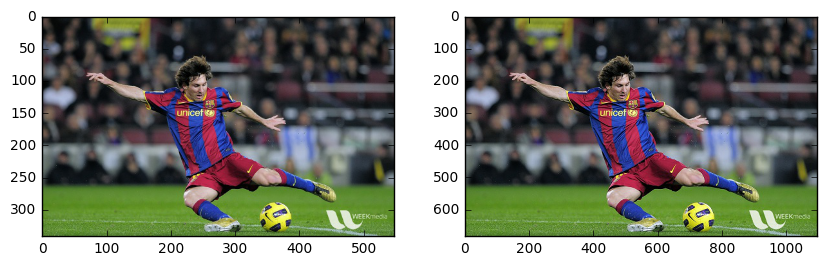

In [2]:
# Scaling
img = cv2.imread('images/messi.jpg')
height, width = img.shape[:2]
res = cv2.resize(img,(2*width, 2*height), interpolation = cv2.INTER_CUBIC)

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

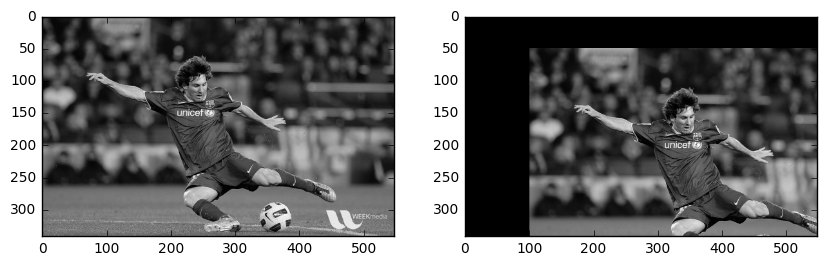

In [3]:
# Translation
img = cv2.imread('images/messi.jpg', cv2.IMREAD_GRAYSCALE)
rows,cols = img.shape

M = np.float32([[1,0,100],[0,1,50]])
dst = cv2.warpAffine(img,M,(cols,rows))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(dst, cmap='gray')

[[  6.12323400e-17   1.00000000e+00   1.03000000e+02]
 [ -1.00000000e+00   6.12323400e-17   4.45000000e+02]]


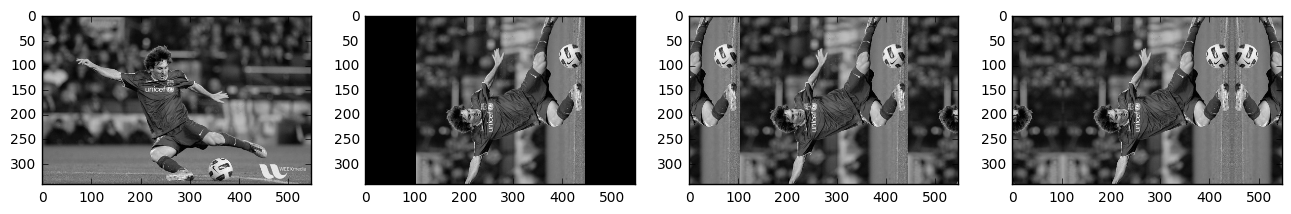

In [4]:
# Rotation
img = cv2.imread('images/messi.jpg', cv2.IMREAD_GRAYSCALE)
rows,cols = img.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
print M
dst1 = cv2.warpAffine(img,M,(cols,rows))
dst2 = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_WRAP)
dst3 = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_REFLECT)

plt.figure(figsize=(16,3))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(dst1, cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(dst2, cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(dst3, cmap='gray')

[[  1.26666667   0.6        -83.33333333]
 [ -0.33333333   1.          66.66666667]]


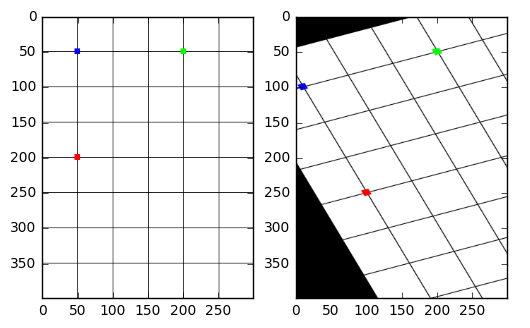

In [5]:
# Affine Transformation
img = cv2.imread('images/drawing.png')
rows,cols,ch = img.shape

pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])

M = cv2.getAffineTransform(pts1,pts2)
print M

dst = cv2.warpAffine(img,M,(cols,rows))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

[[  6.87722951e-02  -1.24273581e+00   6.71000000e+02]
 [  8.66486286e-02   4.83370157e-02   3.14000000e+02]
 [ -7.63013127e-04  -3.68781623e-04   1.00000000e+00]]


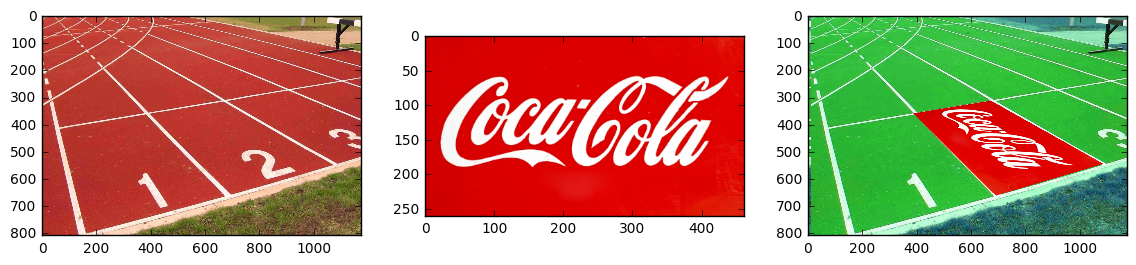

In [6]:
# Homography(Perspective Transformation)
img1 = cv2.imread('images/track.jpg')
img2 = cv2.imread('images/logo.jpg')
rows1,cols1,ch1 = img1.shape
rows2,cols2,ch2 = img2.shape

pts1 = np.float32([(0,0),(cols2-1,0),(cols2-1,rows2-1),(0,rows2-1)])
pts2 = np.float32([(671,314),(1084,546),(689,663),(386,361)])

M = cv2.getPerspectiveTransform(pts1,pts2)
print M
img3 = cv2.warpPerspective(img2,M,(cols1,rows1),None,borderMode=cv2.BORDER_TRANSPARENT)

plt.figure(figsize=(14,3))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

# Homography from SIFT Matching

## 1. SIFT matching from the previous notebook

80 matches


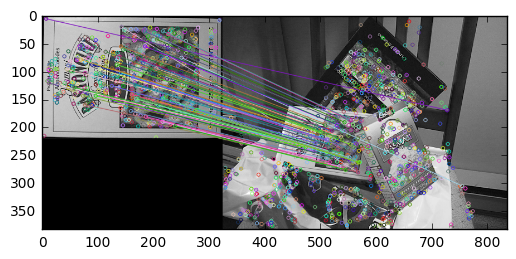

In [7]:
# Open and show images
img1 = cv2.imread('images/box.png')
img2 = cv2.imread('images/box_in_scene.png')

# SIFT feature extracting
sift = cv2.xfeatures2d.SIFT_create()
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# BFMatcher(Brute Force Matcher) with defalut setting
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test as in David Rowe's paper
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
print('%d matches' % len(good_matches))

img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

## 2. Get Homography Matrix & Object Detection

In [8]:
# Matched points
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

print src_pts[:3]
print dst_pts[:3]

[[[ 249.88020325   76.20034027]]

 [[ 142.02658081   20.65104294]]

 [[ 141.46821594   56.05900955]]]
[[[ 429.27371216  306.23214722]]

 [[ 242.53244019  281.81933594]]

 [[ 182.44432068  194.40507507]]]


In [9]:
# Find homography matrix with RANSAC algorithm
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
print M

[[  4.42477074e-01  -1.63242967e-01   1.18844668e+02]
 [  1.15317039e-03   4.05117014e-01   1.60919233e+02]
 [ -2.43906647e-04  -3.51375218e-04   1.00000000e+00]]


In [10]:
# Calculate the object position in the scene using homography
h,w = img1.shape[0:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
print dst

[[[ 118.84466553  160.91923523]]

 [[  89.59349823  272.07879639]]

 [[ 267.45895386  297.94100952]]

 [[ 284.15066528  175.08525085]]]


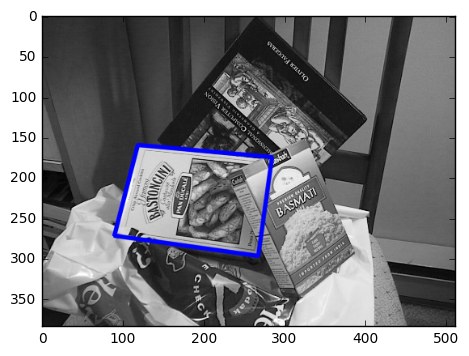

In [11]:
# Display the object
img2 = cv2.polylines(img2,[np.int32(dst)],True,(255,0,0),3, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

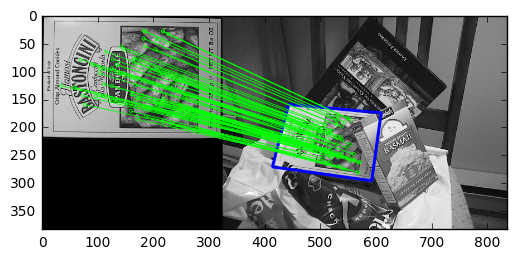

In [12]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None,**draw_params)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

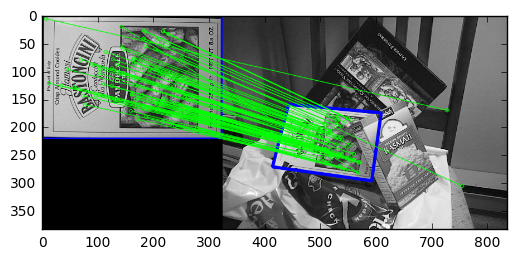

In [13]:
# Display the object
img1 = cv2.polylines(img1,[np.int32(pts)],True,(255,0,0),3, cv2.LINE_AA)
img2 = cv2.polylines(img2,[np.int32(dst)],True,(255,0,0),3, cv2.LINE_AA)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None,**draw_params)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))